[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [20]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were looking for places to go around the world?", name="Bot")]
messages.append(HumanMessage(f"Yes, I am interested in Italy. But what other places can i go to?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were looking for places to go around the world?
================================ Human Message =================================
Name: Lance

Yes, I am interested in Italy. But what other places can i go to?


Recall we can pass them to a chat model.

In [21]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content="Italy is a fantastic choice with its rich history, art, and delicious cuisine. Beyond Italy, there are many other wonderful destinations to consider, each offering unique experiences:\n\n1. **France**: Known for its beautiful countryside, incredible cuisine, and world-class art and fashion. Paris, the Loire Valley, and the French Riviera are highlights.\n\n2. **Spain**: Offers vibrant cities like Barcelona and Madrid, stunning architecture, and diverse landscapes. Don't miss the beaches in the south and the unique Basque culture in the north.\n\n3. **Greece**: Famous for its ancient history and beautiful islands. Athens and the islands of Santorini and Mykonos are top destinations.\n\n4. **Japan**: A blend of ancient tradition and cutting-edge modernity. Explore Tokyo's bustling streets, Kyoto's temples, and Hokkaido's natural beauty.\n\n5. **Australia**: Known for its stunning natural landscapes, from the Great Barrier Reef to the Outback, and vibrant cities like Sy

We can run our chat model in a simple graph with `MessagesState`.

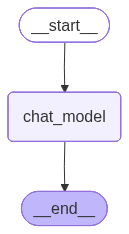

In [22]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were looking for places to go around the world?
================================ Human Message =================================
Name: Lance

Yes, I am interested in Italy. But what other places can i go to?
================================== Ai Message ==================================

Italy is a fantastic choice with its rich history, stunning landscapes, and delicious cuisine. In addition to Italy, here are a few other places around the world that you might find interesting:

1. **Japan** - Known for its blend of traditional culture and cutting-edge technology, with attractions like Tokyo, Kyoto's historic temples, and the beautiful cherry blossoms in spring.

2. **New Zealand** - Famous for its stunning natural landscapes, from beaches to mountains, and known for outdoor adventures like hiking and bungee jumping.

3. **Peru** - Home to the ancient Incan city of Machu Picchu

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

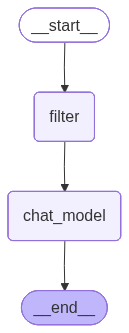

In [24]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were looking for places to go around the world?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I am interested in Italy. But what other places can i go to?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were looking for places to go around the world?
================================ Human Message =================================
Name: Lance

Yes, I am interested in Italy. But what other places can i go to?
================================== Ai Message ==================================

Italy is a fantastic choice with its rich history, culture, and cuisine. If you're open to exploring other destinations, here are a few suggestions that might interest you:

1. **Spain**: Discover vibrant cities like Barcelona and Madrid, relax on the beaches of the Costa del Sol, or explore the unique architecture of Seville and Granada.

2. **France**: From the romance of Paris to the stunning landscapes of Provence and the French Riviera, France offers diverse attractions.

3. **Greece**: Explore the historic sites of Athens, relax on the picturesque islands of Santorini and Mykonos, or delve

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

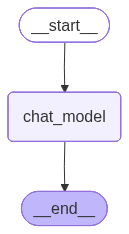

In [28]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [30]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about France!", name="Kashvi"))

In [31]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were looking for places to go around the world?
================================ Human Message =================================
Name: Lance

Yes, I am interested in Italy. But what other places can i go to?
================================== Ai Message ==================================

Italy is a fantastic choice with its rich history, culture, and cuisine. If you're open to exploring other destinations, here are a few suggestions that might interest you:

1. **Spain**: Discover vibrant cities like Barcelona and Madrid, relax on the beaches of the Costa del Sol, or explore the unique architecture of Seville and Granada.

2. **France**: From the romance of Paris to the stunning landscape

In [32]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were looking for places to go around the world?
================================ Human Message =================================
Name: Lance

Yes, I am interested in Italy. But what other places can i go to?
================================== Ai Message ==================================

Italy is a fantastic choice with its rich history, culture, and cuisine. If you're open to exploring other destinations, here are a few suggestions that might interest you:

1. **Spain**: Discover vibrant cities like Barcelona and Madrid, relax on the beaches of the Costa del Sol, or explore the unique architecture of Seville and Granada.

2. **France**: From the romance of Paris to the stunning landscape

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

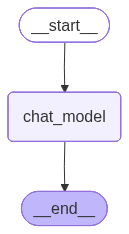

In [33]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me what are some places in France!", name="Lance"))

In [35]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=True
        )

[AIMessage(content="\nFrance's influence on world history and culture is profound, making it a fascinating subject of study and a popular destination for travelers worldwide.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 529, 'prompt_tokens': 17, 'total_tokens': 546, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a788c5aef0', 'id': 'chatcmpl-CTsdgO7PYjxoSTjjR1ceoLRACR6Om', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--064d2bef-c5af-4e94-84cf-a3d52b97e952-0', usage_metadata={'input_tokens': 17, 'output_tokens': 529, 'total_tokens': 546, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 HumanMessage(

In [36]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r